## **Librerie**

In [1]:
import pandas as pd
import holidays
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import seaborn as sns
from scipy.stats import f_oneway

## **Importo dataset**

- **Ristoranti**

In [2]:
restaurants = pd.read_csv('restaurants.csv', sep=";")

In [3]:
restaurants.head()

,data,scontrini,lordototale,ristorante
0,20180101,21884.0,765441.81,R000
1,20180101,28101.0,1197357.21,R001
2,20180101,19961.0,385808.08,R003
3,20180101,23173.0,789949.23,R004
4,20180101,19541.0,624257.76,R005


Converto la **data**:

In [4]:
restaurants['data'] = pd.to_datetime(restaurants['data'], format='%Y%m%d')

In [5]:
restaurants.head()

,data,scontrini,lordototale,ristorante
0,2018-01-01,21884.0,765441.81,R000
1,2018-01-01,28101.0,1197357.21,R001
2,2018-01-01,19961.0,385808.08,R003
3,2018-01-01,23173.0,789949.23,R004
4,2018-01-01,19541.0,624257.76,R005


- **Città**

In [6]:
towns = pd.read_excel('Restaurant-Town.xlsx', header = None)

In [7]:
towns.head()

,0,1
0,R000,Montebello
1,R003,Piacenza
2,R005,Voghera
3,R004,Stradella
4,R001,Piacenza


Rinomino **colonnne**:

In [8]:
towns.columns = ['ristorante', 'città']

## Uso dati dal 2019

Prima i dati per **scontrini** e **lordototale** sono presi mensilmente, non si può fare analisi sulle time series

In [9]:
start_date = pd.Timestamp(2019, 9, 1)
restaurants = restaurants[restaurants['data'] >= start_date]

## Unifico i due dataset

In [10]:
rest_towns = pd.merge(restaurants, towns, on='ristorante', how='inner')

In [11]:
rest_towns.head()

,data,scontrini,lordototale,ristorante,città
0,2019-09-01,1128.0,43535.8994,R000,Montebello
1,2019-09-02,600.0,22753.8220,R000,Montebello
2,2019-09-03,681.0,23561.0718,R000,Montebello
3,2019-09-04,732.0,26180.0287,R000,Montebello
4,2019-09-05,773.0,27926.4818,R000,Montebello


## Estraggo il giorno della settimana

In [12]:
rest_towns['day'] = rest_towns['data'].dt.strftime('%A')

## Aggiungo festività

Uso libreria **holidays**

In [13]:
def get_holiday(date):
    year = date.year
    it_holidays = holidays.Italy(years=year)
    return it_holidays.get(date)

In [14]:
rest_towns['festività'] = rest_towns['data'].apply(get_holiday)

In [15]:
rest_towns.head()

,data,scontrini,lordototale,ristorante,città,day,festività
0,2019-09-01,1128.0,43535.8994,R000,Montebello,Sunday,None
1,2019-09-02,600.0,22753.8220,R000,Montebello,Monday,None
2,2019-09-03,681.0,23561.0718,R000,Montebello,Tuesday,None
3,2019-09-04,732.0,26180.0287,R000,Montebello,Wednesday,None
4,2019-09-05,773.0,27926.4818,R000,Montebello,Thursday,None


# ANALISI ESPOLRATIVA DEI DATI

## Scatterplot scontrini/lordo nel tempo

Per il ristorante **zero**:

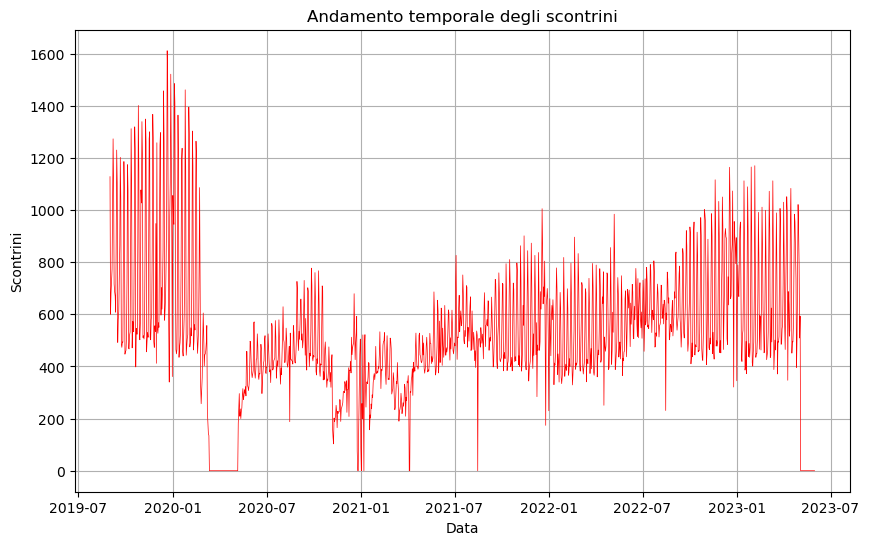

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(rest_towns[rest_towns['ristorante']=='R000']['data'],rest_towns[rest_towns['ristorante']=='R000']['scontrini'],
         linewidth=0.5, color='red')
plt.title('Andamento temporale degli scontrini')
plt.xlabel('Data')
plt.ylabel('Scontrini')
plt.grid(True)
plt.show()

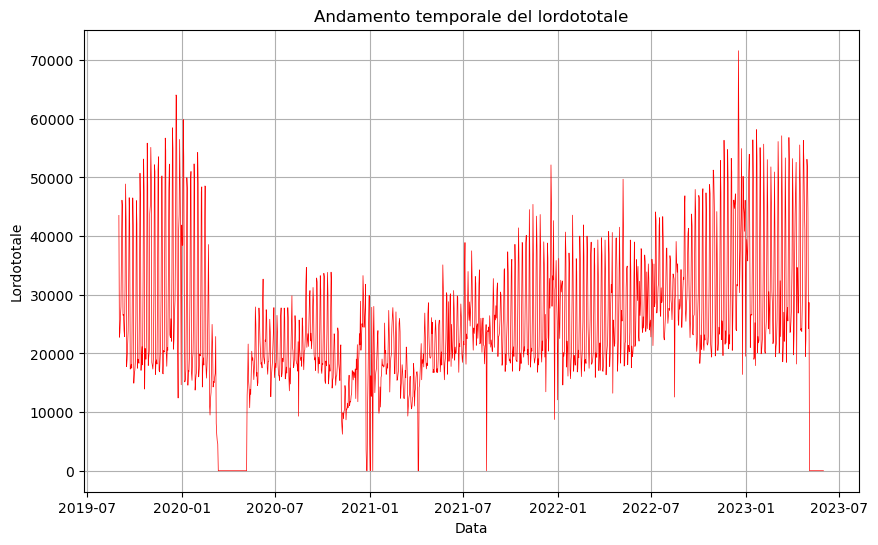

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(rest_towns[rest_towns['ristorante']=='R000']['data'], rest_towns[rest_towns['ristorante']=='R000']['lordototale'],
         color='red', linewidth=0.5)
plt.title('Andamento temporale del lordototale')
plt.xlabel('Data')
plt.ylabel('Lordototale')
plt.grid(True)

# Salva il grafico ad alta qualità
plt.savefig('grafico_alta_qualita.png', dpi=300, bbox_inches='tight')

plt.show()

## Verifico se scontrini e lordo totale hanno lo stesso trend o meno

**Scatterplot**: se ha andamento circa lineare allora sono proporzionali

Per ridondanza guardo solo il ristorante analizzato prima (poi vediamo):

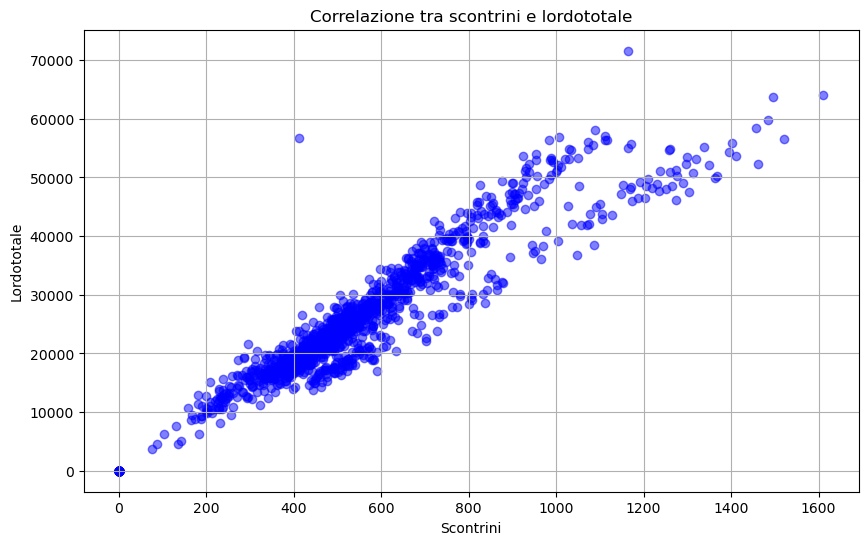

In [18]:
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(rest_towns[rest_towns['ristorante']=='R000']['scontrini'], rest_towns[rest_towns['ristorante']=='R000']['lordototale'], color='blue', alpha=0.5)

# Titoli ed etichette
plt.title('Correlazione tra scontrini e lordototale')
plt.xlabel('Scontrini')
plt.ylabel('Lordototale')
plt.grid(True)

plt.show()

Aggiungo **linea di tendenza**:

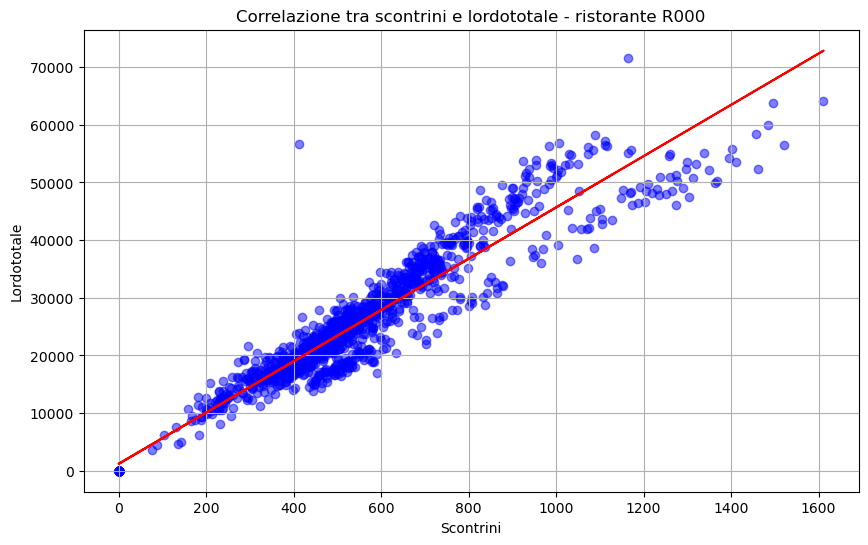

In [19]:
plt.figure(figsize=(10, 6))

rist1 = rest_towns[rest_towns['ristorante'] == 'R000']

plt.scatter(rist1['scontrini'], rist1['lordototale'], color='blue', alpha=0.5)

m, b = np.polyfit(rist1['scontrini'], rist1['lordototale'], 1)

# Aggiunge la linea di tendenza al grafico
plt.plot(rist1['scontrini'], m * rist1['scontrini'] + b, color='red')

plt.title('Correlazione tra scontrini e lordototale - ristorante R000')
plt.xlabel('Scontrini')
plt.ylabel('Lordototale')
plt.grid(True)

# Salva il grafico ad alta qualità
plt.savefig('correlazione.png', dpi=300, bbox_inches='tight')

plt.show()

In [20]:
rist1.to_csv("Rist1.csv")

In [21]:
predicted_values = m * np.array(rist1['scontrini']) + b

# calcola R^2
residuals = np.array(rist1['lordototale']) - predicted_values
ss_res = np.sum(residuals**2)
ss_tot = np.sum((np.array(rist1['lordototale']) - np.mean(rist1['lordototale']))**2)
r2 = 1 - (ss_res / ss_tot)

print(f"R^2: {r2:.2f}")


R^2: 0.91


Coefficiente angolare = prezzo medio a scontrino

In [22]:
m

44.4669484923145

Una volta verificato che sono circa proporzionali tra loro, uso una sola delle due variabili per controllare quali sono i valori più frequenti calcolando le densità per i vari ristoranti:

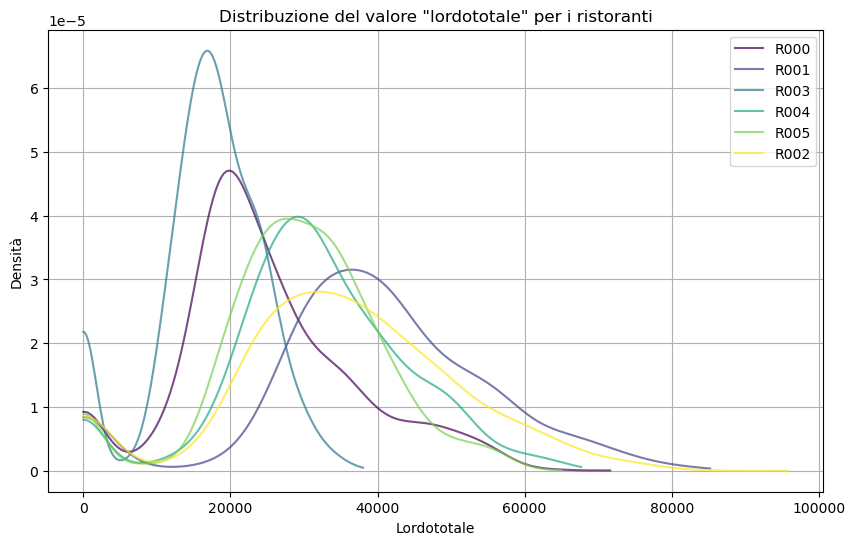

In [23]:
unique_restaurants = rest_towns['ristorante'].unique()
plt.figure(figsize=(10, 6))

# Creare una serie di colori
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_restaurants)))

for restaurant, color in zip(unique_restaurants, colors):
    restaurant_data = rest_towns[rest_towns['ristorante'] == restaurant]['lordototale'].values
    density = gaussian_kde(restaurant_data)
    xs = np.linspace(restaurant_data.min(), restaurant_data.max(), 200)
    plt.plot(xs, density(xs), label=restaurant, color=color, alpha=0.7)

plt.title('Distribuzione del valore "lordototale" per i ristoranti')
plt.xlabel('Lordototale')
plt.ylabel('Densità')
plt.legend()
plt.grid(True)
# Salva il grafico ad alta qualità
plt.savefig('densitá_lordototale.png', dpi=300, bbox_inches='tight')
plt.show()

**Boxplot** distribuzione scontrni e lordo totale per ciascun ristorante:

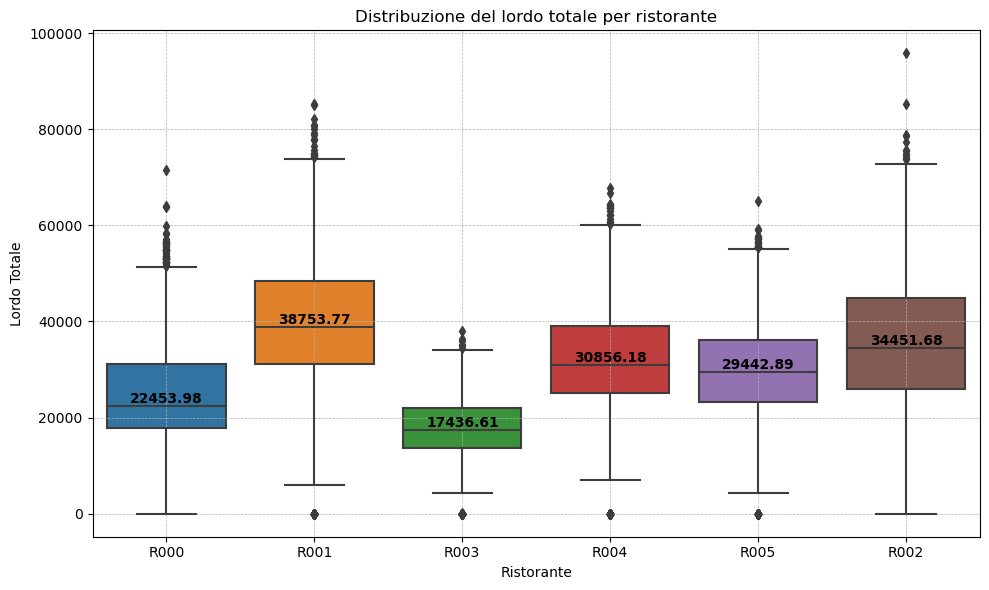

In [24]:
# Creare una figura e un solo asse
fig, ax = plt.subplots(figsize=(10, 6))

offset = 1500

# Grafico sul singolo asse
sns.boxplot(x='ristorante', y='lordototale', data=rest_towns, ax=ax)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
for i, tipo in enumerate(rest_towns['ristorante'].unique()):
    vendite_tipo = rest_towns[rest_towns['ristorante'] == tipo]['lordototale']
    median = np.percentile(vendite_tipo, 50)
    ax.text(i, median + offset, f"{median:.2f}", ha='center', va='center', fontweight='bold', color='black')
ax.set_title('Distribuzione del lordo totale per ristorante')
ax.set_xlabel('Ristorante')
ax.set_ylabel('Lordo Totale')

# Ajusta gli spazi per evitare sovrapposizioni
plt.tight_layout()

# Salva il grafico ad alta qualità
plt.savefig('boxplot_lordototale.png', dpi=300, bbox_inches='tight')
plt.show()

In base al **tipo di giornata**

In [25]:
rest_towns['tipogiornata'] = rest_towns['day'].apply(lambda x: 'Weekend' if (x == 'Saturday' or x == 'Sunday') else 'Feriale')

rest_towns['tipogiornata'] = rest_towns.apply(lambda row: 'Festivo' if row['festività'] is not None else row['tipogiornata'], axis=1)

In [26]:
descrizione = rest_towns.groupby('tipogiornata').describe()
print(descrizione)

             scontrini                                                     \
                 count        mean         std  min    25%    50%     75%   
tipogiornata                                                                
Feriale         5656.0  608.912615  253.327049  0.0  480.0  631.0  765.00   
Festivo          276.0  483.579710  343.084285  0.0  165.5  536.0  757.25   
Weekend         2221.0  725.000900  308.103851  0.0  564.0  750.0  926.00   

                     lordototale                                   \
                 max       count          mean           std  min   
tipogiornata                                                        
Feriale       1421.0      5656.0  26829.219956  12788.099523  0.0   
Festivo       1387.0       276.0  25252.755713  18926.901598  0.0   
Weekend       1611.0      2221.0  35825.624268  17215.506057  0.0   

                                                                  
                       25%         50%           75%   

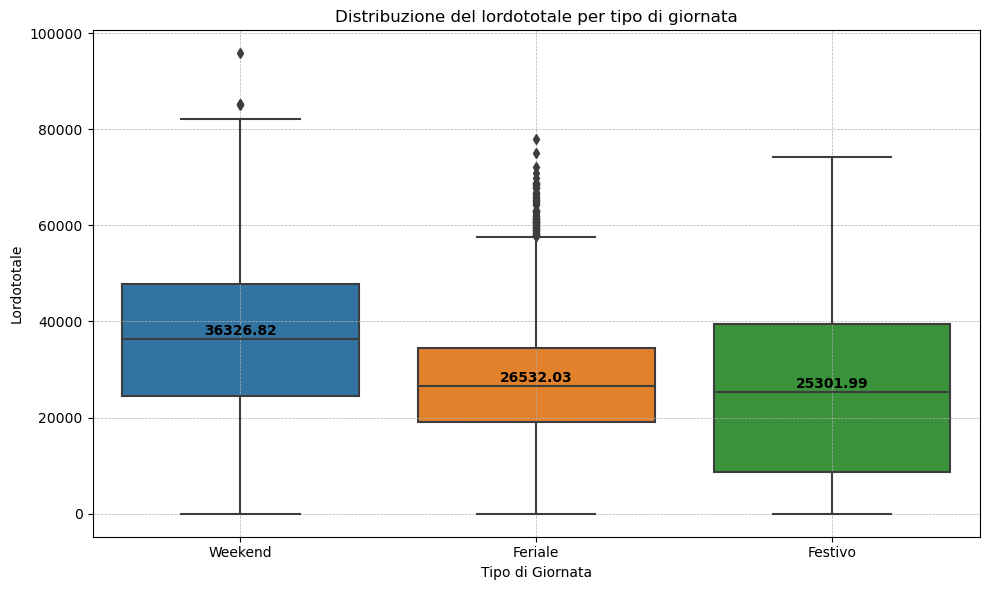

In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Supponiamo che 'rest_towns' sia il tuo DataFrame

fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(x='tipogiornata', y='lordototale', data=rest_towns, ax=ax)

ax.grid(True, which='both', linestyle='--', linewidth=0.5)

offset = 1700  # Adjust this value as needed

# Calcolo e posizionamento delle etichette dei percentili per il grafico
for i, tipo in enumerate(rest_towns['tipogiornata'].unique()):
    vendite_tipo = rest_towns[rest_towns['tipogiornata'] == tipo]['lordototale']
    median = np.percentile(vendite_tipo, 50)
    ax.text(i, median + offset, f"{median:.2f}", ha='center', va='center', fontweight='bold', color='black')

ax.set_title('Distribuzione del lordototale per tipo di giornata')
ax.set_xlabel('Tipo di Giornata')
ax.set_ylabel('Lordototale')

plt.tight_layout()
# Salva il grafico ad alta qualità
plt.savefig('boxplot_festivitá.png', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
group1 = rest_towns[rest_towns['tipogiornata'] == 'Weekend']['scontrini']
group2 = rest_towns[rest_towns['tipogiornata'] == 'Feriale']['scontrini']
group3 = rest_towns[rest_towns['tipogiornata'] == 'Festivo']['scontrini']

# ANOVA
f_stat, p_value = f_oneway(group1, group2, group3)

print(f"F-statistic: {f_stat}")
print(f"p-value: {p_value}")

F-statistic: 189.315248154815
p-value: 4.30637963769577e-81


F è 189.31 e il valore p è estremamente basso (4.31e-81, che è praticamente zero), si può rifiutare con sicurezza l'ipotesi nulla e concludere che c'è una differenza significativa tra le medie degli 'scontrini' nei tre gruppi di giorni.

ed eventualmente procedere con l'analisi eliminando i giorni festivi in quanto non contribuiscono alle predizioni (ho verificato quanto accennato prima).

# TREND STAGIONALITÀ

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [30]:
rist1.set_index('data', inplace=True)

Per il ristorante di prima...

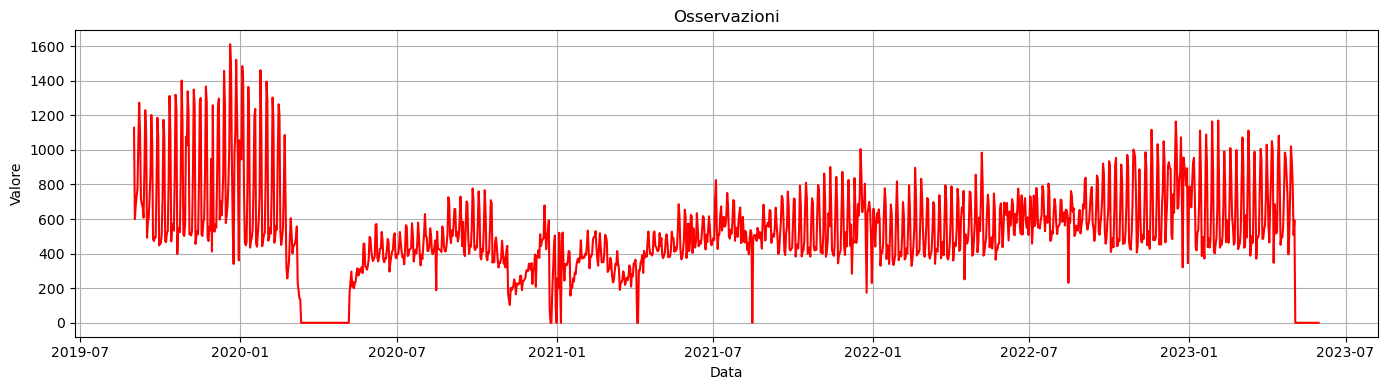

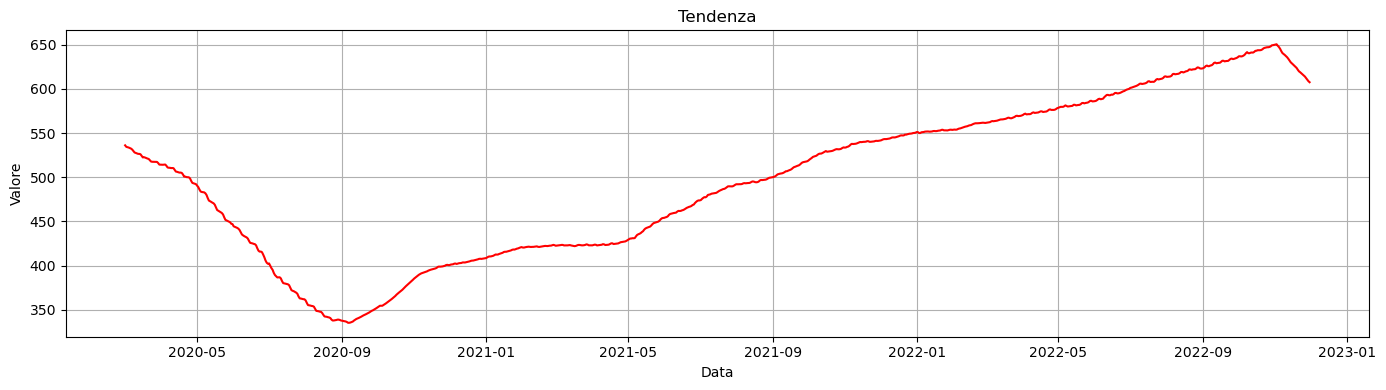

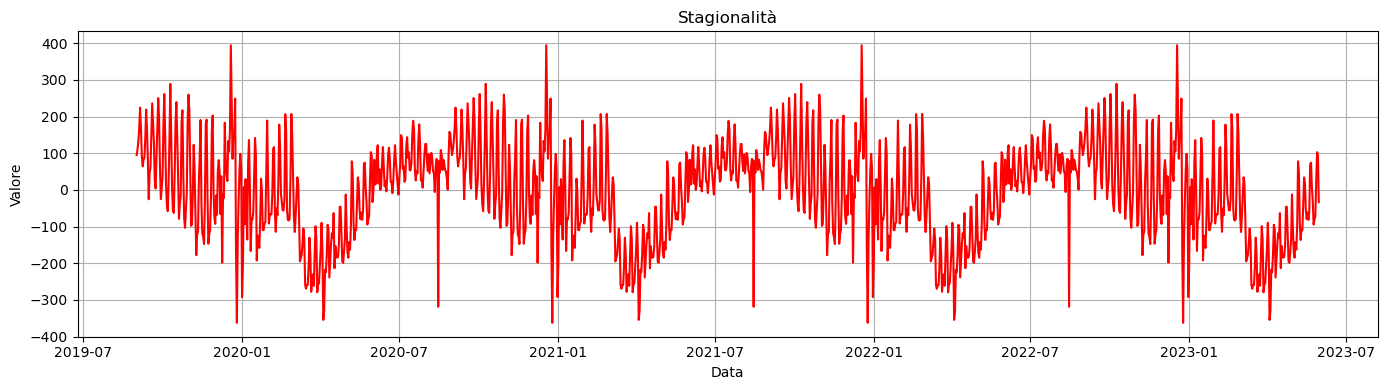

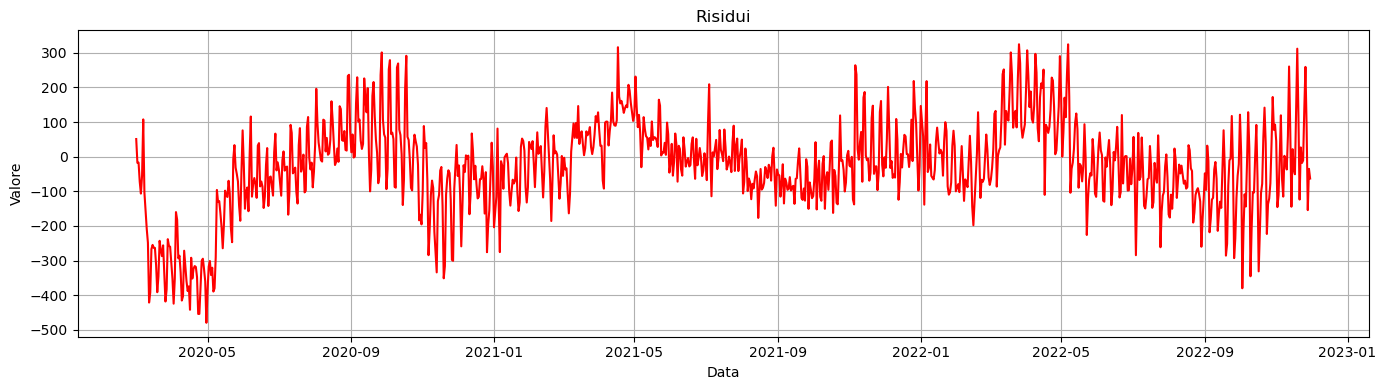

In [31]:
result = seasonal_decompose(rist1['scontrini'], model='additive', period=365)  # o il periodo appropriato

# Osservazioni
# -> Serie originale
plt.figure(figsize=(14, 4))
plt.plot(result.observed, color = 'red')
plt.title('Osservazioni')
plt.xlabel('Data')
plt.ylabel('Valore')
plt.grid(True)
plt.tight_layout()
plt.show()

# Tendenza
# Trend
plt.figure(figsize=(14, 4))
plt.plot(result.trend, color = 'red')
plt.title('Tendenza')
plt.xlabel('Data')
plt.ylabel('Valore')
plt.grid(True)
plt.tight_layout()
plt.show()

# Stagionalità
plt.figure(figsize=(14, 4))
plt.plot(result.seasonal, color = 'red')
plt.title('Stagionalità')
plt.xlabel('Data')
plt.ylabel('Valore')
plt.grid(True)
plt.tight_layout()
plt.show()

# Risidui -> è quelo che devo usare nel caso di ARIMA perchè non considera la stagionalità e il trend (residui = parte stazionaria)
plt.figure(figsize=(14, 4))
plt.plot(result.resid, color = 'red')
plt.title('Risidui')
plt.xlabel('Data')
plt.ylabel('Valore')
plt.grid(True)
plt.tight_layout()
plt.show()

Dal grafico delle osservazioni la serie sembra avere un comportamento non stazionario con trend crescente. 

### Test per verificare se è stazionaria o meno

#### 1. ACF e PACF

MA(q) : ACF diversa da zero per h<=q (con q >=1) e uguale a zero per h>q
        PACF che decade geometricamente (lentamente tipo) verso zero
        
AR(p) : PACF diversa da zero per h<=p (con p >=1) e uguale a zero per h>p
        ACF che decade geometricamente (lentamente tipo) verso zero
        
MODELLO ARMA(p,q): ACF e PACF hanno caratteristiche miste. 
       ACF decade geometricamente ma a partire da h>q
       PACF decade geometricamente ma a partire da h>p

per capire che modello devo usare, calcolo ACF e PACF.
Una volta visti i grafici cerco di capire a quale di questi assomiglia di più: ci sono dei test da fare.
uno di questi test è un **intervallo di confidenza** 

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<Figure size 1400x700 with 0 Axes>

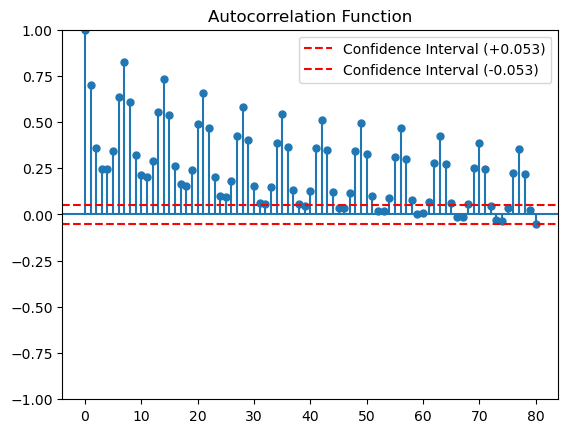

<Figure size 1400x700 with 0 Axes>

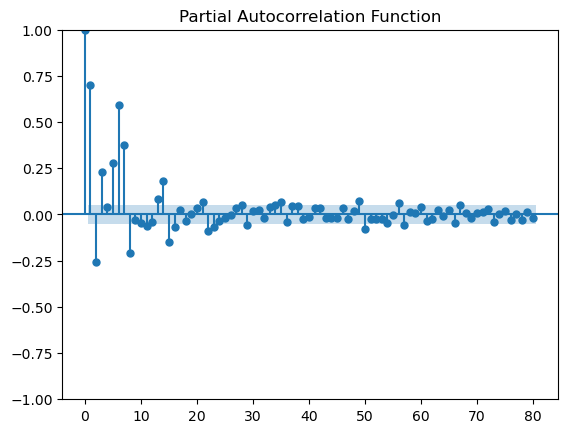

In [33]:
series = rist1['lordototale'].dropna()
T = len(series)

# Calcolare l'intervallo di confidenza
conf_interval = 1.96/np.sqrt(T)

# Plot ACF
plt.figure(figsize=(14, 7))
plot_acf(series, lags=80, title='Autocorrelation Function', alpha=None)
plt.axhline(y=conf_interval, color='r', linestyle='--', label=f'Confidence Interval (+{conf_interval:.3f})')
plt.axhline(y=-conf_interval, color='r', linestyle='--', label=f'Confidence Interval (-{conf_interval:.3f})')
plt.legend(loc='upper right')
plt.show()

# Plot PACF
plt.figure(figsize=(14, 7))
plot_pacf(series, lags=80, title='Partial Autocorrelation Function', method='ywm')
plt.show()

Senza covid...

In [34]:
start_date_nocov = pd.Timestamp(2020, 5, 7)
nocov = rist1[rist1.index >= start_date_nocov]

<Figure size 1400x700 with 0 Axes>

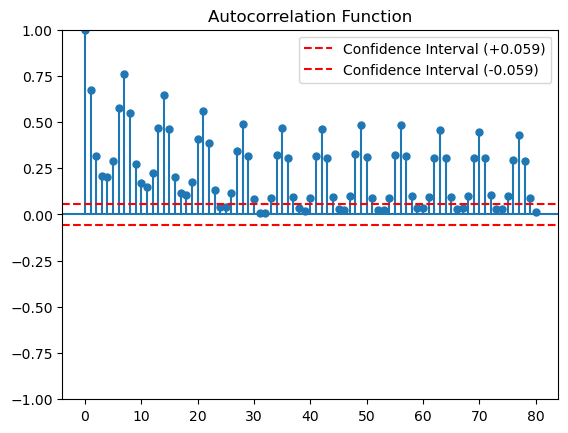

<Figure size 1400x700 with 0 Axes>

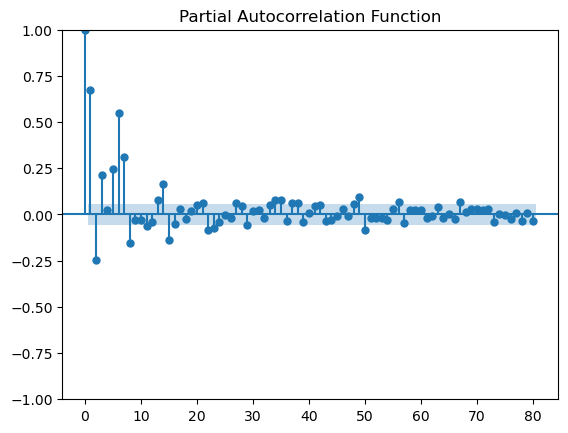

In [35]:
series = nocov['lordototale'].dropna()
T = len(series)

# Calcolare l'intervallo di confidenza
conf_interval = 1.96/np.sqrt(T)# Plot ACF


plt.figure(figsize=(14, 7))
plot_acf(series, lags=80, title='Autocorrelation Function', alpha=None)
plt.axhline(y=conf_interval, color='r', linestyle='--', label=f'Confidence Interval (+{conf_interval:.3f})')
plt.axhline(y=-conf_interval, color='r', linestyle='--', label=f'Confidence Interval (-{conf_interval:.3f})')
plt.legend(loc='upper right')
plt.show()

# Plot PACF
plt.figure(figsize=(14, 7))
plot_pacf(series, lags=80, title='Partial Autocorrelation Function', method='ywm')
plt.show()

Una volta calcolato l'intervallo di confidenza si osserva che (escludendo covid, volendo posso fare un confronto) le **autocorrelazioni** sono statisticamente diverse da zero (quasi per ogni lag) e il loro valore oscilla periodicamente a partire dal 23° lag circa (evidente segno di presenza di trend stagionali, a intervalli regolari di lag ho valori che sono correlati sempre allo stesso modo).


Per quanto riguarda le **autocorrelazioni parziali** si nota un comportamento erratico per i primi 15 lag circa, al di la dei quali si stabilizza verso lo zero (plausibile segnale che le correlazioni temporali sono esaustivamente spiegate dai primi 15 lag).

Togliendo il covid si è semplicemente 'anticipato' quello che è il trend.

#### 2. Lyung-Box

Inserisco il test di **Ljung-Box**: testa se un gruppo di coefficienti di correlazione *consecutivi* sono significativamente diversi da zero.

Formalmente, si tratta di un test sull'ipotesi nulla che i dati sono indipendenti, ovvero che non c'è autocorrelazione fino a un certo ritardo k. 

Se il test rifiuta l'ipotesi nulla, ciò suggerisce la presenza di autocorrelazione nei dati, indicando che il modello potrebbe non essere adeguato.

In [36]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [37]:
series = rist1['lordototale']

ljung_box_results = acorr_ljungbox(series, lags=[10])  # puoi cambiare il valore di 'lags' in base alle tue esigenze

print("Statistiche di Test:", ljung_box_results['lb_stat'])
print("P-value:", ljung_box_results['lb_pvalue'])

Statistiche di Test: 10    3390.052918
Name: lb_stat, dtype: float64
P-value: 10    0.0
Name: lb_pvalue, dtype: float64


**Statistiche di Test (lb_stat):** Il valore di 3390.05 è molto alto, il che è un forte indicatore contro l'ipotesi nulla (che non c'è autocorrelazione nei residui).

**P-value (lb_pvalue):** Un p-value di 0.0 è molto basso, ben al di sotto di qualsiasi livello di significatività tipico (come 0.05 o 0.01). Questo significa che rifiutiamo l'ipotesi nulla di "non autocorrelazione" con una forte certezza statistica.

Un valore della statistica di test elevato e un p-value basso sono forti indicatori che l'ipotesi nulla di "non autocorrelazione" dovrebbe essere rifiutata.
Ciò suggerisce che la serie temporale *rist1['lordototale']* ha una struttura di autocorrelazione che non è stata catturata da un eventuale modello.
Potrebbe essere necessario considerare un modello di serie temporale più complesso che tenga conto dell'autocorrelazione, come un modello ARIMA con termini AR e/o MA, per meglio adattarsi ai dati.

In [38]:
series = rist1['lordototale']

ljung_box_results = acorr_ljungbox(series, lags=40)

print(ljung_box_results)

        lb_stat      lb_pvalue
1    674.876532  8.691803e-149
2    854.883571  2.314148e-186
3    939.736295  2.126967e-203
4   1022.870413  3.945945e-220
5   1183.899266  9.024679e-254
6   1736.646005   0.000000e+00
7   2672.052408   0.000000e+00
8   3181.374281   0.000000e+00
9   3326.722707   0.000000e+00
10  3390.052918   0.000000e+00
11  3445.590876   0.000000e+00
12  3561.452327   0.000000e+00
13  3983.432308   0.000000e+00
14  4731.590425   0.000000e+00
15  5135.336704   0.000000e+00
16  5232.374476   0.000000e+00
17  5270.076228   0.000000e+00
18  5303.485187   0.000000e+00
19  5384.033420   0.000000e+00
20  5716.485180   0.000000e+00
21  6315.020658   0.000000e+00
22  6619.548217   0.000000e+00
23  6676.326564   0.000000e+00
24  6690.451167   0.000000e+00
25  6702.836070   0.000000e+00
26  6749.460161   0.000000e+00
27  7001.163401   0.000000e+00
28  7474.882702   0.000000e+00
29  7700.046146   0.000000e+00
30  7732.519337   0.000000e+00
31  7738.128265   0.000000e+00
32  7742

In questo output, il test di Ljung-Box è stato eseguito per una gamma di ritardi, da 1 a 40. 
Ogni riga rappresenta i risultati del test per un ritardo diverso.

**lb_stat:** La colonna mostra le statistiche del test per ogni ritardo. Valori elevati suggeriscono una forte evidenza contro l'ipotesi nulla (che i dati non sono autocorrelati).

**lb_pvalue:** Questa colonna mostra i p-value associati alle statistiche del test. Un p-value basso (qui mostrato come 0.000000e+00, che è essenzialmente zero) è una forte evidenza contro l'ipotesi nulla.


Statistiche del Test Elevate: Le statistiche del test sono molto elevate per tutti i ritardi da 1 a 40, il che è un forte indicatore che c'è autocorrelazione nei dati.
P-value Bassi: I p-value sono praticamente zero per tutti i ritardi, il che suggerisce che rifiutiamo l'ipotesi nulla di non autocorrelazione con un'elevata confidenza statistica.
Consistenza: Il fatto che il test dia risultati simili per un'ampia gamma di ritardi suggerisce che la serie ha una struttura di autocorrelazione significativa che persiste attraverso diversi livelli di ritardo.

Qualsiasi gruppo di coeff di corr consecutivi considerati è statisticamente diverso da zero, ad indicare un' onnipresente correlazione nel dataset, la quale, in sede di previsione si rivelerà di grande aiuto.

<div style="text-align: center; color: red;">
    
## 1. ARIMA

</div>

Ora devo lavorare con i soli **residui**:

In [38]:
result = seasonal_decompose(rist1['scontrini'], model='additive', period=365)  # o il periodo appropriato

In [39]:
residual = result.resid.dropna()

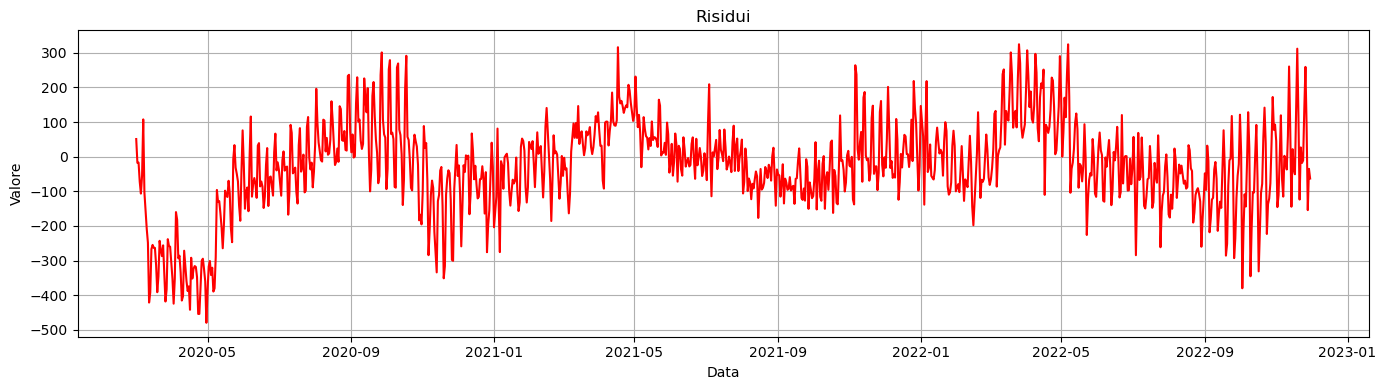

In [40]:
plt.figure(figsize=(14, 4))
plt.plot(residual, color = 'red')
plt.title('Risidui')
plt.xlabel('Data')
plt.ylabel('Valore')
plt.grid(True)
plt.tight_layout()
plt.show()

### Controllo che siano stazionari

#### 1. ACF/PACF

<Figure size 1400x700 with 0 Axes>

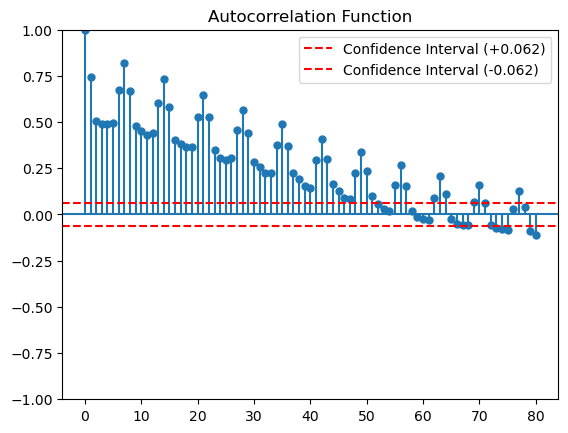

<Figure size 1400x700 with 0 Axes>

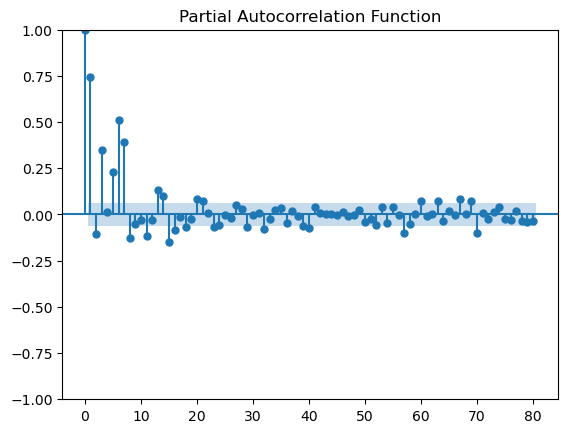

In [41]:
T = len(residual)

# Calcolare l'intervallo di confidenza
conf_interval = 1.96/np.sqrt(T)

# Plot ACF
plt.figure(figsize=(14, 7))
plot_acf(residual, lags=80, title='Autocorrelation Function', alpha=None)
plt.axhline(y=conf_interval, color='r', linestyle='--', label=f'Confidence Interval (+{conf_interval:.3f})')
plt.axhline(y=-conf_interval, color='r', linestyle='--', label=f'Confidence Interval (-{conf_interval:.3f})')
plt.legend(loc='upper right')
plt.show()

# Plot PACF
plt.figure(figsize=(14, 7))
plot_pacf(residual, lags=80, title='Partial Autocorrelation Function', method='ywm')
plt.show()

#### 2. Ljung-Box

In [42]:
ljung_box_results = acorr_ljungbox(residual, lags=[10])  # puoi cambiare il valore di 'lags' in base alle tue esigenze

print("Statistiche di Test:", ljung_box_results['lb_stat'])
print("P-value:", ljung_box_results['lb_pvalue'])

Statistiche di Test: 10    3579.753312
Name: lb_stat, dtype: float64
P-value: 10    0.0
Name: lb_pvalue, dtype: float64


In [43]:
ljung_box_results = acorr_ljungbox(residual, lags=40)

print(ljung_box_results)

        lb_stat      lb_pvalue
1    557.402852  3.087369e-123
2    815.055235  1.030397e-177
3   1058.458978  3.743175e-229
4   1299.521878  4.225043e-280
5   1549.583498   0.000000e+00
6   2005.925926   0.000000e+00
7   2685.754441   0.000000e+00
8   3137.711251   0.000000e+00
9   3371.800928   0.000000e+00
10  3579.753312   0.000000e+00
11  3769.729887   0.000000e+00
12  3965.700233   0.000000e+00
13  4338.360375   0.000000e+00
14  4885.805428   0.000000e+00
15  5234.618626   0.000000e+00
16  5402.668345   0.000000e+00
17  5552.757305   0.000000e+00
18  5688.394543   0.000000e+00
19  5826.080673   0.000000e+00
20  6110.347402   0.000000e+00
21  6541.985097   0.000000e+00
22  6825.517922   0.000000e+00
23  6952.309486   0.000000e+00
24  7049.105186   0.000000e+00
25  7137.620107   0.000000e+00
26  7233.190584   0.000000e+00
27  7447.596001   0.000000e+00
28  7781.057652   0.000000e+00
29  7984.707878   0.000000e+00
30  8069.858181   0.000000e+00
31  8137.088372   0.000000e+00
32  8188

Bisogna ora vedere che tipo di serie stazionaria è. 
Potrebe essere:
- ARMA complesso
- ARIMA (cioè devo differenziare ancora una volta i residui per ottenere residui stazionari)

Per far ciò usiamo il **test di Dickey-Fuller**:
In particolare, il test è usato per verificare l'ipotesi nulla che una unit root sia presente in una serie temporale. Se l'ipotesi nulla può essere respinta, si può concludere che la serie è stazionaria, o quantomeno "tendenzialmente" stazionaria.

In [44]:
from statsmodels.tsa.stattools import adfuller

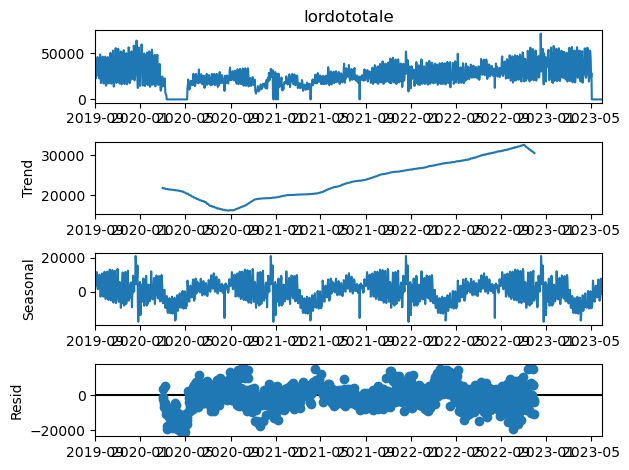

Residuals are already stationary.


In [45]:
result = seasonal_decompose(rist1['lordototale'], model='additive', period=365)

# Plot the original data, the trend, the seasonality, and the residuals
result.plot()
plt.show()

# Function to perform Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series.dropna(), autolag='AIC')
    return result[1] <= 0.05  # Return True if p-value is <= 0.05

# Check if residuals are stationary
if not adf_test(result.resid):
    print("Residuals are not stationary. Applying differencing.")
    
    # Apply regular differencing to make residuals stationary
    resid_diff = result.resid.diff().dropna()
    
    # Check for stationarity again
    if not adf_test(resid_diff):
        print("Residuals are still not stationary. Applying seasonal differencing.")
        
        # Apply seasonal differencing
        seasonal_diff = resid_diff.diff(365).dropna()
        
        if adf_test(seasonal_diff):
            print("Residuals are now stationary.")
        else:
            print("Residuals are still not stationary. Further differencing may be required.")
    else:
        print("Residuals are now stationary.")

    # Plot differenced residuals
    plt.figure(figsize=(12, 6))
    plt.title('Differenced Residuals')
    plt.plot(seasonal_diff)
    plt.show()
else:
    print("Residuals are already stationary.")

#### Provo con modello **ARIMA**

In [48]:
from pmdarima import auto_arima
from pmdarima import ARIMA
from itertools import product

In [49]:
# Definisci i range dei parametri
p_values = range(0, 6)
d_values = range(0, 4)
q_values = range(0, 6)

# Crea una lista per memorizzare i risultati
results = []

# Esegui un ciclo attraverso tutte le combinazioni di parametri
for p, d, q in product(p_values, d_values, q_values):
    try:
        # Addestra il modello ARIMA
        model = ARIMA(order=(p, d, q), seasonal_order=(0, 0, 0, 0)).fit(y=residual)
        
        # Ottieni i criteri informativi
        aic = model.aic()
        bic = model.bic()
        
        # Aggiungi i risultati alla lista
        results.append((p, d, q, aic, bic))
        
    except:
        # Gestisci eventuali errori (es. problemi di convergenza)
        continue

# Ordina i risultati in base all'AIC e stampa i primi 3
sorted_by_aic = sorted(results, key=lambda x: x[3])[:3]
print("Top 3 modelli in base all'AIC:")
for p, d, q, aic, bic in sorted_by_aic:
    print(f'ARIMA({p}, {d}, {q}) - AIC: {aic}, BIC: {bic}')

# Ordina i risultati in base al BIC e stampa i primi 3
sorted_by_bic = sorted(results, key=lambda x: x[4])[:3]
print("\nTop 3 modelli in base al BIC:")
for p, d, q, aic, bic in sorted_by_bic:
    print(f'ARIMA({p}, {d}, {q}) - AIC: {aic}, BIC: {bic}')


C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so in

C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency in

C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency in

C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarn

C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters fou

C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information

C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarnin

C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No f

C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarnin

C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No f

C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No f

Top 3 modelli in base all'AIC:
ARIMA(4, 1, 5) - AIC: 11117.104446799207, BIC: 11171.133667101976
ARIMA(5, 0, 5) - AIC: 11127.907435648272, BIC: 11186.86034949419
ARIMA(5, 1, 5) - AIC: 11165.322251567288, BIC: 11224.263219170309

Top 3 modelli in base al BIC:
ARIMA(4, 1, 5) - AIC: 11117.104446799207, BIC: 11171.133667101976
ARIMA(5, 0, 5) - AIC: 11127.907435648272, BIC: 11186.86034949419
ARIMA(5, 1, 4) - AIC: 11168.174808365924, BIC: 11222.204028668693


C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Procedo ora a compilare ARIMA con i migliori valori trovati:

In [50]:
from statsmodels.tsa.arima.model import ARIMA

In [51]:
model = ARIMA(residual, order=(4, 1, 5))  # d = 0 poiché i residui sono già stazionari
model_fit = model.fit()

C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


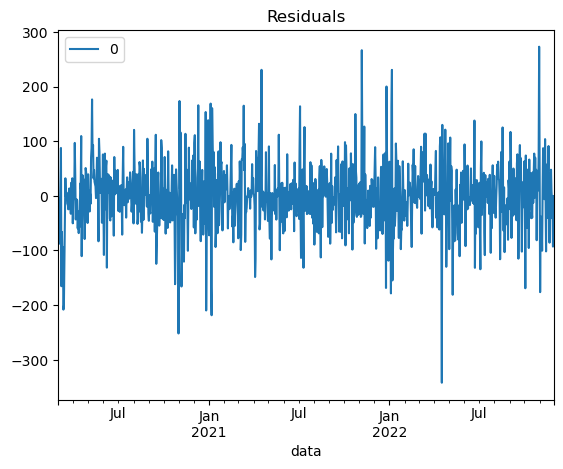

In [52]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title="Residuals")
plt.show()

In [53]:
forecast = model_fit.forecast(steps=10)
print('10-day forecast:', forecast)

10-day forecast: 2022-12-01    -79.340320
2022-12-02     90.484911
2022-12-03    226.504848
2022-12-04     48.727674
2022-12-05   -110.590582
2022-12-06    -44.429900
2022-12-07    -39.132395
2022-12-08    -79.979528
2022-12-09     88.273765
2022-12-10    219.321209
Freq: D, Name: predicted_mean, dtype: float64


**Bozza codice train e test per MSE (vanno aggiunte altre metriche anche)**

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [55]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [56]:
train_size = int(len(residual) * 0.8)
train, test = residual[0:train_size], residual[train_size:len(residual)]

# Crea e allena il modello ARIMA
# Sostituire con i tuoi valori ottimali di p, d, q
model = ARIMA(train, order=(4, 1, 5))
model_fit = model.fit()

# Esegui la previsione
forecast = model_fit.forecast(steps=len(test))

# Calcola l'errore quadratico medio (MSE)
mse = mean_squared_error(test, forecast)

# Calcola la radice dell'errore quadratico medio (RMSE)
rmse = np.sqrt(mse)

# Calcola l'errore assoluto medio (MAE)
mae = mean_absolute_error(test, forecast)

# Calcola l'errore percentuale assoluto medio (MAPE)
mape = mean_absolute_percentage_error(test, forecast)

print('RMSE:', rmse)
print('MSE:', mse)
print('MAE:', mae)
print('MAPE:', mape)

C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE: 136.7284886545983
MSE: 18694.679609770617
MAE: 114.2340766581269
MAPE: 402.2226563242075


C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Procedere con:
- altre metriche
- cose della scaletta che ho saltati (tipo akaike, qesta era solo una prova)

AIC: 8898.212945470681
BIC: 8945.096492610148


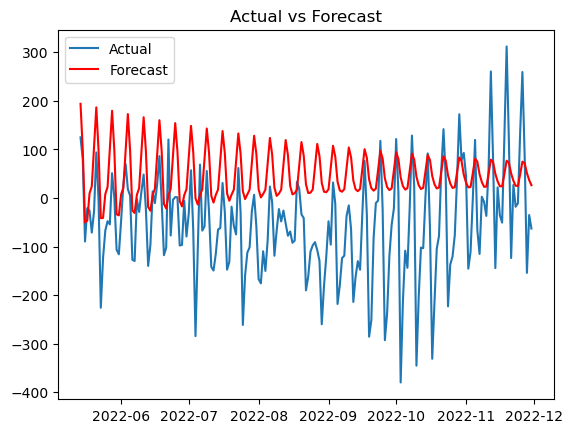

In [57]:
# Calcolo AIC e BIC
aic = model_fit.aic
bic = model_fit.bic
print('AIC:', aic)
print('BIC:', bic)

# Confronto le previsioni con i dati effettivi
plt.plot(test, label='Actual')
plt.plot(forecast, color='red', label='Forecast')
plt.legend()
plt.title('Actual vs Forecast')
plt.show()

<div style="text-align: center; color: red;">
    
## 2. SARIMA

</div>

In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

Se lavoro con SARIMA considero la serie in se:

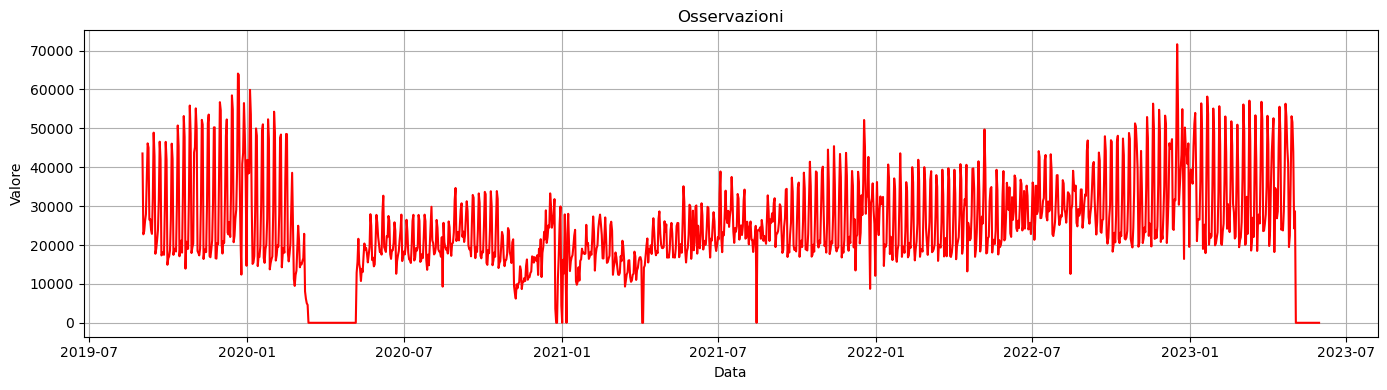

In [59]:
plt.figure(figsize=(14, 4))
plt.plot(result.observed, color = 'red')
plt.title('Osservazioni')
plt.xlabel('Data')
plt.ylabel('Valore')
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

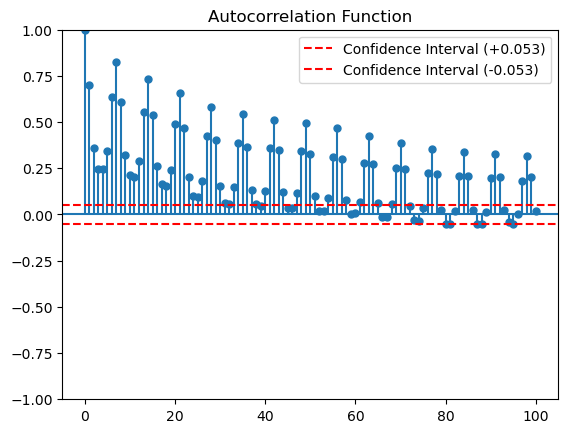

<Figure size 1400x700 with 0 Axes>

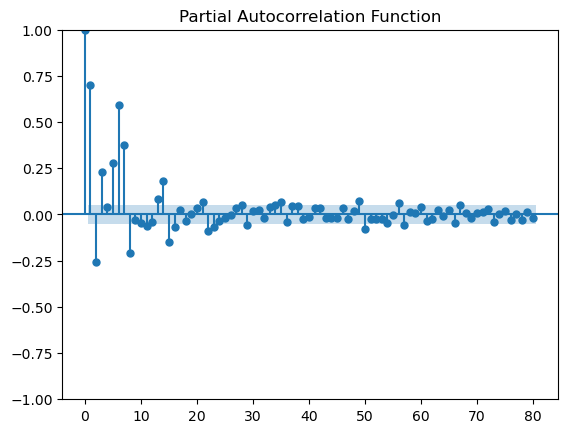

In [60]:
series = rist1['lordototale'].dropna()
T = len(series)

# Calcolare l'intervallo di confidenza
conf_interval = 1.96/np.sqrt(T)

# Plot ACF
plt.figure(figsize=(14, 7))
plot_acf(series, lags=100, title='Autocorrelation Function', alpha=None)
plt.axhline(y=conf_interval, color='r', linestyle='--', label=f'Confidence Interval (+{conf_interval:.3f})')
plt.axhline(y=-conf_interval, color='r', linestyle='--', label=f'Confidence Interval (-{conf_interval:.3f})')
plt.legend(loc='upper right')
plt.show()

# Plot PACF
plt.figure(figsize=(14, 7))
plot_pacf(series, lags=80, title='Partial Autocorrelation Function', method='ywm')
plt.show()

In [61]:
train_size = int(len(rist1['lordototale']) * 0.8)
train, test = rist1[0:train_size], rist1[train_size:]

In [62]:
model = auto_arima(train['lordototale'], seasonal=True, m=365,
                   start_p=4, start_q=5, d=1,  # fissiamo la componente ARIMA a (4,1,5)
                   max_p=4, max_q=5, max_d=1,  # fissiamo i massimi anche uguali ai valori di partenza
                   start_P=0, start_Q=0, max_P=3, max_Q=3,
                   trace=True, error_action='ignore', suppress_warnings=True,
                   stepwise=False, n_jobs=-1, information_criterion='bic')

MemoryError: Unable to allocate 1.09 GiB for an array with shape (1095, 366, 366) and data type float64

Nel codice sotto va sostituito il set di parametri con i valori trovati sopra:

In [ ]:
# Stima dei parametri SARIMA
order = (4, 1, 5)  # Ordine dei componenti ARIMA non stagionali
seasonal_order = (1, 1, 9, 365)  # Ordine dei componenti SARIMA stagionali
seasonal_period = 365

# Addestramento del modello SARIMA
model = SARIMAX(rist1['lordototale'], order=order, seasonal_order=seasonal_order, seasonal_period = seasonal_period)
model_fit = model.fit()

# Valutazione del modello
forecast = model_fit.forecast(steps=10)  # Esempio: previsione a 10 giorni
print('10-day forecast:', forecast)

# Calcolo dell'errore quadratico medio (MSE) e radice dell'errore quadratico medio (RMSE)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
print('RMSE:', rmse)

# Calcolo AIC e BIC
aic = model_fit.aic
bic = model_fit.bic
print('AIC:', aic)
print('BIC:', bic)

# Grafico delle previsioni vs. dati effettivi
plt.plot(test, label='Actual')
plt.plot(forecast, color='red', label='Forecast')
plt.legend()
plt.title('Actual vs Forecast')
plt.show()


C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Matteo Corona\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


## 2. Effetto condizioni meteo (Piacenza)

### questa cosa la mettiamo dopo, una volta fatta l'analisi vedo se il meteo può essere utile o meno per spiegare i miei dati. Non ha senso maneggiare troppo i dati a priori

Trovato **dati meteo storici** per le 4 località. Integriamo per vedere se le condizioni meteo hanno effetto su scontrini e lordo totale.

Come prima cosa verifichiamo quali sono le colonne effettivamente utli per l'analisi:

In [ ]:
Piacenza = rest_towns[rest_towns['città']=='Piacenza']
MeteoPiacenza = pd.read_csv('/Users/maggio2023/Desktop/DatasetMeteoDSlab/PiacenzaMeteo.csv')
MeteoPiacenza.head()

In [ ]:
numeric_columns = MeteoPiacenza.select_dtypes(include=np.number)
correlation_matrix = numeric_columns.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
numeric_columns.columns

Useremo dunque solo le colonne:
- VENTOMEDIA
- TMEDIA °C
- UMIDITÀ
- VISIBILITÀ
in quanto le altre sono in qualche modo ridondanti

In [ ]:
MeteoPiacenzaRel = MeteoPiacenza.drop(['TMIN °C', 'TMAX °C', 'PUNTORUGIADA °C', 'VENTOMAX km/h', 'RAFFICA km/h',
       'PRESSIONESLM mb', 'PRESSIONEMEDIA mb', 'PIOGGIA mm'], axis = 1)

In [ ]:
MeteoPiacenzaRel['FENOMENI'].unique()

Iniziamo a **INTEGRARE** i dataset:

In [ ]:
MeteoPiacenzaRel['DATA'] = pd.to_datetime(MeteoPiacenzaRel['DATA'], dayfirst=True).dt.strftime('%Y-%m-%d')
MeteoPiacenzaRel

In [ ]:
MeteoPiacenzaRel.rename(columns={'DATA': 'data'}, inplace=True)
MeteoPiacenzaRel['data'] = pd.to_datetime(MeteoPiacenzaRel['data'])
MeteoPiacenzaRel

In [ ]:
Piacenza = rest_towns[rest_towns['città'] == 'Piacenza']
Piacenza

In [ ]:
PiacenzaIntegratedNan = pd.merge(MeteoPiacenzaRel, Piacenza, on = 'data', how='outer')
PiacenzaIntegratedNan

In [ ]:
unique_values = PiacenzaIntegratedNan['tipogiornata'].unique()

for value in unique_values:
    subset = PiacenzaIntegratedNan[PiacenzaIntegratedNan['tipogiornata'] == value]
    numeric_columns = subset.select_dtypes(include=np.number)
    correlation_matrix = numeric_columns.corr()
    
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Matrice di Correlazione per {value}')
    plt.show()

In [ ]:
PiacenzaIntegratedNan['FENOMENI'].fillna('Niente', inplace=True)

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='scontrini', y='FENOMENI', data=PiacenzaIntegratedNan, orient='h')
plt.title('Distribuzione degli scontrini per condizioni atmosferiche')
plt.show()

# Boxplot per la colonna 'lordototale'
plt.figure(figsize=(12, 6))
sns.boxplot(x='lordototale', y='FENOMENI', data=PiacenzaIntegratedNan, orient='h')
plt.title('Distribuzione di Lordo Totale per condizioni atmosferiche')
plt.show()